---
## **Matrix Factorization using Deep Network (Recommendation)**
---

[Ref.]
  - https://hackernoon.com/autoencoders-deep-learning-bits-1-11731e200694
  - http://katbailey.github.io/post/matrix-factorization-with-tensorflow/
  - https://www.oreilly.com/ideas/deep-matrix-factorization-using-apache-mxnet
  - http://nicolas-hug.com/blog/matrix_facto_3

<br/>

### **1) Recommendation 방식**



<br/>
- 기본적인 Recommendation의 구조는 아래와 같이 1) 사용자(User) x 2) 아이템(Item) 간의 스코어 matrix 형태로 표현할 수 있음
<br/>
![recomm._mat](recomm._mat.png)
<br/>
- Recommendation을 하기 위해 사용자그룹의 기존(과거) 구매/평점기록 데이터를 활용함
- 그러나 모든 사용자가 모든 아이템에 대한 구매/평점 기록이 없기에 전체 사용자 x 아이템으로 표현되는 Recommendation Matrix는 Sparse & Incomplete한 형태가 됨
- 이 Incomplete Matrix의 Missing Values를 찾는 것이 Recommendation Algorithm의 목적
- 크게 2가지 형태의 Recommendation Algorithm이 있음

  **1) Collaborative Filtering (User-based or Item-based)**
    - 협업필터링 방식으로 추천하고자 하는 대상과 가장 유사한 사용자그룹 혹은 아이템그룹의 유사도와 과거 구매/평점기록을 이용하여 추천하는 방식
    - 그룹 간 유사도를 계산하는 방식으로 Cosine Similarity을 일반적으로 많이 이용함 
    - Missing value에 대한 예측 시 (User or Item) Similairty와 기 존재하는 구매/평점기록값(구매 or 별점)과의 가중평균으로 계산 함
    
    (참조 : https://buildingrecommenders.wordpress.com/2015/11/18/overview-of-recommender-algorithms-part-2/)
    - 1) User-Based CF
        - 추천대상과 유사한 사용자 그룹을 파악하고, 해당 그룹이 많이 사용/구매한 아이템을 추천하는 방식
        - 알고리즘 구현이 간단한 편이지만, 유저가 많아질 수록 연산이 복잡함 (nC2 경우의 수가 많아짐)
    - 2) Item-Based CF
        - 아이템간의 유사도 matrix를 기반으로, 특정 아이템을 추천하는 방식 (가중평균)
        - User-Based CF에 비해 연산이 가벼운 편이지만, 개인 성향을 반영하기 어려움
<br/>
![CF_ex](CF_ex.png)
<br/>

  **2) Matrix Factorization**
    - Sparse & Incomplete Recommendation을 2개 이상의 Low Rank Matrices로 Decomposition하는 방식
    - Decomposition하는 2개의 Matrices는 추천대상(User) / 아이템(Item) Matrix로 나눠 짐
    - 협업 필터링과 달리 사용자(User) / 아이템(Item)의 특성을 표현하는 Latent Factor (:= Embedding values)로 표현함
    [Ex) 2 Dimension Latent Factor으로 표현한 예시]
<br/>
![mat_fact](mat_fact.png)
<br/>
    - Latent Factor로 표현된 2개의 Matrix의 Dot Product가 Recommendation Matrix의 추천 값이 되며, 이 값 중 과거 기록과의 차이를 최소화 하는 Latent Matrix를 찾는 것이 목적
    - Performance Metric으로 RMSE를 주로 사용함
    - 일반적으로 Latent Facotr의 Dimension은 User / Item의 Dimension보다 작은 값을 이용
    - Matrix Factorization 방법으로 PCA / SVD 방법등이 있지만, Sparse & Incomplete Matrix이기에 Latent Matrices에 초기값을 주고 Iteration 마다 최적값을 찾아가는 Optimization 방법을 주로 이용
    - 본 스터디에서는 Optimization 방법 중 Deep Learning Framework를 이용한 Vanila Matrix Factorization 방법과 Deep Matrix Facotrization 방법을 소개 함

 <br/>
- **Deep Matrix Factorization의 장점**
    - Flatten Layer를 사용하기 때문에 Embedding Layer의 Latent Dimension의 크기를 다르게 가져갈 수 있음 (Ex. User는 10차원, Item은 5차원)
    - Vanilla Matrix Factorization은 User간 or Item간의 Inter-connection의 영향을 반영하기 어렵지만, Flatten으로 펼쳐서 학습하기 떄문에 User간, Item간, User-Item간의 Inter-connection을 학습할 수 있음
    - Vanilla Matrix Factorization에서 불가능한 non-linear connections을 표현 가능
    - Latent Factor를 표현하는 Embedding Layer를 2개 이상 할 수 있음 (Flatten 함수 써서)
    - Dot Product가 없기에 학습속도가 훨씬 빠름

 <br/>

In [1]:
%pylab inline
import mxnet as mx
import pandas
import seaborn; seaborn.set_style('whitegrid')
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Gluon module load
import mxnet as mx
import numpy as np
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn

ctx = mx.cpu()

---
### **1) Vanila Matrix Facotrization using synthetic data**
---

- 2개의 low rank latent matrix의 dot product로 예측하는 일반적인 Matrix Facotrization 방법
- 2개의 latent matrix rank는 같음
- rank <= input dimension

Synthetic data set is generated. [row num : 35000]


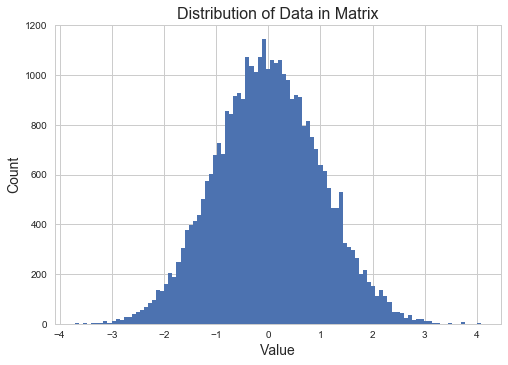

It appears to be a normal distribution that is centered around 0 with a variance of 1


In [3]:
## Generate random synthetic data set (250 users x 250 movies)
X = numpy.random.randn(250, 250) # 250x250 = 62,500 complete data set (no missing values)

# extract subset of data (Assume this is only given data)
n = 35000
i = numpy.random.randint(250, size=n) # Generate random row indexes
j = numpy.random.randint(250, size=n) # Generate random column indexes
X_values = X[i, j]
print("Synthetic data set is generated. [row num : {}]".format(X_values.shape[0]))

# distribution of extracted values
plt.title("Distribution of Data in Matrix", fontsize=16)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Value", fontsize=14)
plt.hist(X_values, bins=100)
plt.show()

print('It appears to be a normal distribution that is centered around 0 with a variance of 1')

In [4]:
## Make Vanila Matrix Factorization(MF) using Gluon hybrid-block 
class Vanilla_MF(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Vanilla_MF, self).__init__(**kwargs)
        with self.name_scope():
            self.user = nn.Embedding(input_dim=250, output_dim=25) # Embedding Layer for Users (25 latent factors)
            self.movie = nn.Embedding(input_dim=250, output_dim=25) # Embedding Layer for Movies (25 latent factors)
            self.flat = nn.Flatten()
            
    def hybrid_forward(self, F, user_i, movie_i):
        # Here `F` can be either mx.nd or mx.sym, x is the input data,
        user_i = self.user(user_i)
        movie_i = self.movie(movie_i)
        z = F.sum(F.dot(user_i, movie_i, transpose_b=True), axis = 1) # Dot product of users x movies and rowwise sum of result
#         z = self.flat(z)
        return z

In [5]:
# model initialization
model = Vanilla_MF()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

learning_rate = 1e-4
criterion = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model.collect_params(), 'adam',
                          {'learning_rate': learning_rate,
                           'wd': 1e-5})

In [6]:
# Embedding layer latent factors
user_latent_v = model.user.weight.data().asnumpy()
print("User embedding layer shape : {}\n".format(user_latent_v.shape))
item_latent_v = model.movie.weight.data().asnumpy()
print("Item embedding layer shape : {}\n".format(item_latent_v.shape))

print("25 Embedding latents factors of the first user : \n{}".format(user_latent_v[0]))

User embedding layer shape : (250, 25)

Item embedding layer shape : (250, 25)

25 Embedding latents factors of the first user : 
[ 0.08690061  0.11293826 -0.10049446  0.12735233 -0.03226358  0.10438174
  0.12894627 -0.00171298  0.04623531 -0.14136802  0.01747404  0.06442726
  0.05782974 -0.0706878  -0.11482002 -0.03529139 -0.03970727 -0.08992843
  0.09868617  0.060701   -0.09062057 -0.02898844  0.10589617  0.02242789
 -0.11005463]


In [7]:
# User rating sample by dot product of user x item embedding matrix
user_i = 1
movie_i = 2

# naive dot product example
user_v = user_latent_v[user_i]
movie_v = item_latent_v[movie_i]
print("Dot product of {}th user and {}th movie : {:.4f}".format(user_i, movie_i, np.dot(user_v,movie_v)))

# dot product using gluon network 
user_n = mx.nd.array([user_i])
item_n = mx.nd.array([movie_i])
print("Model result of {}th user and {}th movie : {:.4f}".format(user_i, movie_i, model(user_n, item_n).asnumpy()[0]))

Dot product of 1th user and 2th movie : -0.0330
Model result of 1th user and 2th movie : -0.0330


In [8]:
# Make batch input using gluon DataLoader
batch_size = 10000
X_train = gluon.data.DataLoader(gluon.data.ArrayDataset(i[:25000].astype('float32'), j[:25000].astype('float32'), X_values[:25000].astype('float32')),
                                      batch_size=batch_size, shuffle=True)

X_eval = gluon.data.DataLoader(gluon.data.ArrayDataset(i[25000:].astype('float32'), j[25000:].astype('float32'), X_values[25000:].astype('float32')),
                                      batch_size=batch_size, shuffle=True)

In [9]:
# Epoch Running Function
def run_epoch(model, X_train, X_eval, num_epochs = 20):
    for epoch in range(num_epochs):
        running_loss = 0.0
        val_loss = 0.0
        n_total = 0.0

        # for training
        for user, movie, rating in X_train:
            user = user.as_in_context(ctx)
            movie = movie.as_in_context(ctx)
            rating = rating.as_in_context(ctx)

            with mx.autograd.record():
                output = model(user, movie)
                loss = criterion(output, rating)
            loss.backward()
            optimizer.step(user.shape[0])
            running_loss += mx.nd.sum(loss).asscalar()
            n_total += user.shape[0]

        for val_user, val_movie, val_rating in X_eval:
            val_user = val_user.as_in_context(ctx)
            val_movie = val_movie.as_in_context(ctx)

            with mx.autograd.record():
                val_output = model(val_user, val_movie)
                val_loss_tmp = criterion(val_output, val_rating)
            val_loss += mx.nd.sum(val_loss_tmp).asscalar()

        # ===================log========================
        print('epoch [{}/{}], (rmse) loss:{:.4f}, (rmse) val_loss:{:.4f}'
              .format(epoch + 1, num_epochs, np.sqrt(running_loss / n_total), np.sqrt(val_loss / n_total)))
    return model

In [10]:
## Model Running (Training)
model = run_epoch(model, X_train, X_eval, num_epochs= 20)

epoch [1/20], (rmse) loss:15.2509, (rmse) val_loss:10.1072
epoch [2/20], (rmse) loss:14.2606, (rmse) val_loss:9.5894
epoch [3/20], (rmse) loss:13.2654, (rmse) val_loss:9.1010
epoch [4/20], (rmse) loss:12.7117, (rmse) val_loss:8.6405
epoch [5/20], (rmse) loss:11.9225, (rmse) val_loss:8.2088
epoch [6/20], (rmse) loss:11.5516, (rmse) val_loss:7.8047
epoch [7/20], (rmse) loss:10.5129, (rmse) val_loss:7.4306
epoch [8/20], (rmse) loss:10.1461, (rmse) val_loss:7.0836
epoch [9/20], (rmse) loss:9.6921, (rmse) val_loss:6.7610
epoch [10/20], (rmse) loss:8.9398, (rmse) val_loss:6.4634
epoch [11/20], (rmse) loss:8.6287, (rmse) val_loss:6.1872
epoch [12/20], (rmse) loss:8.2749, (rmse) val_loss:5.9286
epoch [13/20], (rmse) loss:7.7057, (rmse) val_loss:5.6873
epoch [14/20], (rmse) loss:7.3769, (rmse) val_loss:5.4616
epoch [15/20], (rmse) loss:7.2322, (rmse) val_loss:5.2511
epoch [16/20], (rmse) loss:6.5863, (rmse) val_loss:5.0548
epoch [17/20], (rmse) loss:6.4270, (rmse) val_loss:4.8688
epoch [18/20],

#### Problem of the totally and randomly generated data set : no strong connections(dependencies) between two latent matrices
- If there does not exist connections(dependencies) between two latent matrices, the performance of Vanilla MF does not seem to get increased well. 
- And this is because we generated the data using total random normal. 
- It is like  he "movie watchers" don't have any preferences, they just randomly like or don't like movies! It would be impossible to predict

Synthetic data set is generated. [row num : 35000]


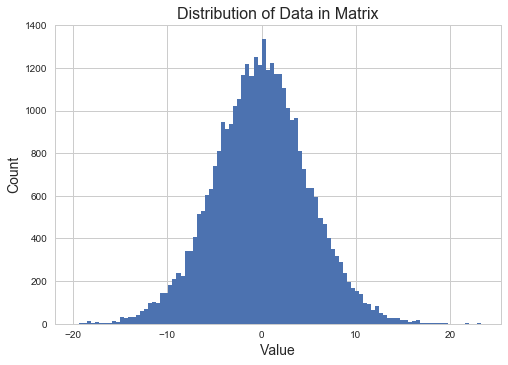

It appears to be a normal distribution that is centered around 0 but lager variance than original synthetic data set


In [11]:
## Generate synthetic data set using two row rank latent matrix (randomly generated) 
### -> It essentially makes the connections between latents matrix
a = numpy.random.normal(0, 1, size=(250, 25)) # Generate random numbers for the first skinny matrix
b = numpy.random.normal(0, 1, size=(25, 250)) # Generate random numbers for the second skinny matrix

X = a.dot(b) # Build our real data matrix from the dot product of the two skinny matrices

n = 35000
i = numpy.random.randint(250, size=n)
j = numpy.random.randint(250, size=n)
X_values = X[i, j]
print("Synthetic data set is generated. [row num : {}]".format(X_values.shape[0]))

# distribution of extracted values
plt.title("Distribution of Data in Matrix", fontsize=16)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Value", fontsize=14)
plt.hist(X_values, bins=100)
plt.show()

print('It appears to be a normal distribution that is centered around 0 but lager variance than original synthetic data set')

In [12]:
batch_size = 10000
X_train = gluon.data.DataLoader(gluon.data.ArrayDataset(i[:25000].astype('float32'), j[:25000].astype('float32'), X_values[:25000].astype('float32')),
                                      batch_size=batch_size, shuffle=True)

X_eval = gluon.data.DataLoader(gluon.data.ArrayDataset(i[25000:].astype('float32'), j[25000:].astype('float32'), X_values[25000:].astype('float32')),
                                      batch_size=batch_size, shuffle=True)

In [13]:
# model initialization
model = Vanilla_MF()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

learning_rate = 1e-4
criterion = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model.collect_params(), 'adam',
                          {'learning_rate': learning_rate,
                           'wd': 1e-5})

In [14]:
## Model Running (Training)
model = run_epoch(model, X_train, X_eval, num_epochs= 20)

epoch [1/20], (rmse) loss:12.8799, (rmse) val_loss:8.8683
epoch [2/20], (rmse) loss:12.0156, (rmse) val_loss:8.4129
epoch [3/20], (rmse) loss:11.4499, (rmse) val_loss:7.9831
epoch [4/20], (rmse) loss:11.0393, (rmse) val_loss:7.5826
epoch [5/20], (rmse) loss:10.1923, (rmse) val_loss:7.2090
epoch [6/20], (rmse) loss:9.9205, (rmse) val_loss:6.8638
epoch [7/20], (rmse) loss:9.1769, (rmse) val_loss:6.5462
epoch [8/20], (rmse) loss:8.7725, (rmse) val_loss:6.2545
epoch [9/20], (rmse) loss:8.3774, (rmse) val_loss:5.9883
epoch [10/20], (rmse) loss:8.0528, (rmse) val_loss:5.7448
epoch [11/20], (rmse) loss:7.6219, (rmse) val_loss:5.5244
epoch [12/20], (rmse) loss:7.4772, (rmse) val_loss:5.3223
epoch [13/20], (rmse) loss:7.0268, (rmse) val_loss:5.1380
epoch [14/20], (rmse) loss:6.8421, (rmse) val_loss:4.9706
epoch [15/20], (rmse) loss:6.9309, (rmse) val_loss:4.8176
epoch [16/20], (rmse) loss:6.5381, (rmse) val_loss:4.6779
epoch [17/20], (rmse) loss:6.1961, (rmse) val_loss:4.5530
epoch [18/20], (rm

---
### **2) Deep matrix Facotrization using synthetic data**
---

- 기존 two latent matrix의 dot product 곱의 형태가 아닌 방식
- Two latent layer(matrix)를 concat 후 Flatten하는 방식 사용
- 이후 Regression 형태[0,1]의 결과값을 얻기 위해 Fully Connected Layer를 사용하여 Output 산출

<br/>
<img src="deep_mf.png" width="700">
<br/>


In [15]:
class Deep_MF(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Deep_MF, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.user = nn.Embedding(input_dim=250, output_dim=25)
            self.movie = nn.Embedding(input_dim=250, output_dim=25)
            
            
            self.out = gluon.nn.HybridSequential('output_')
            with self.out.name_scope(): # Output layers to make regression result
                self.out.add(nn.Flatten())
                self.out.add(nn.Dense(64, activation='relu'))
                self.out.add(nn.Dense(1)) # the last output layer
            
    def hybrid_forward(self, F, user_i, movie_i):
        # Here `F` can be either mx.nd or mx.sym, x is the input data,
        user_i = self.user(user_i)
        movie_i = self.movie(movie_i)
        
        z = F.concat(user_i, movie_i) # Two latent layer(matrix) concat
        z = self.out(z) # concat output -> flatten -> dense layer(64 dim) -> output layer(1 dim)
        return z

In [16]:
# model initialization
model = Deep_MF()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

learning_rate = 1e-2 # 기존 Vanilla 모형에 비해 running 속도가 빠름, 그러나 학습속도가 느리기에 learning_rate를 높임
criterion = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model.collect_params(), 'adam',
                          {'learning_rate': learning_rate,
                           'wd': 1e-5})

In [17]:
## Model Running (Training)
model = run_epoch(model, X_train, X_eval, num_epochs= 500)

epoch [1/500], (rmse) loss:3.5841, (rmse) val_loss:2.2236
epoch [2/500], (rmse) loss:3.5731, (rmse) val_loss:2.2232
epoch [3/500], (rmse) loss:3.5583, (rmse) val_loss:2.2265
epoch [4/500], (rmse) loss:3.5422, (rmse) val_loss:2.2374
epoch [5/500], (rmse) loss:3.5320, (rmse) val_loss:2.2434
epoch [6/500], (rmse) loss:3.5210, (rmse) val_loss:2.2332
epoch [7/500], (rmse) loss:3.5066, (rmse) val_loss:2.2224
epoch [8/500], (rmse) loss:3.4913, (rmse) val_loss:2.2159
epoch [9/500], (rmse) loss:3.4703, (rmse) val_loss:2.2097
epoch [10/500], (rmse) loss:3.4425, (rmse) val_loss:2.2039
epoch [11/500], (rmse) loss:3.4083, (rmse) val_loss:2.1948
epoch [12/500], (rmse) loss:3.3685, (rmse) val_loss:2.1811
epoch [13/500], (rmse) loss:3.3248, (rmse) val_loss:2.1694
epoch [14/500], (rmse) loss:3.2774, (rmse) val_loss:2.1591
epoch [15/500], (rmse) loss:3.2261, (rmse) val_loss:2.1441
epoch [16/500], (rmse) loss:3.1673, (rmse) val_loss:2.1255
epoch [17/500], (rmse) loss:3.1077, (rmse) val_loss:2.1110
epoch 

epoch [140/500], (rmse) loss:1.2566, (rmse) val_loss:1.7404
epoch [141/500], (rmse) loss:1.2516, (rmse) val_loss:1.7408
epoch [142/500], (rmse) loss:1.2461, (rmse) val_loss:1.7390
epoch [143/500], (rmse) loss:1.2435, (rmse) val_loss:1.7427
epoch [144/500], (rmse) loss:1.2412, (rmse) val_loss:1.7416
epoch [145/500], (rmse) loss:1.2335, (rmse) val_loss:1.7420
epoch [146/500], (rmse) loss:1.2284, (rmse) val_loss:1.7416
epoch [147/500], (rmse) loss:1.2232, (rmse) val_loss:1.7437
epoch [148/500], (rmse) loss:1.2167, (rmse) val_loss:1.7421
epoch [149/500], (rmse) loss:1.2135, (rmse) val_loss:1.7437
epoch [150/500], (rmse) loss:1.2087, (rmse) val_loss:1.7454
epoch [151/500], (rmse) loss:1.2076, (rmse) val_loss:1.7422
epoch [152/500], (rmse) loss:1.2019, (rmse) val_loss:1.7421
epoch [153/500], (rmse) loss:1.1982, (rmse) val_loss:1.7448
epoch [154/500], (rmse) loss:1.1934, (rmse) val_loss:1.7412
epoch [155/500], (rmse) loss:1.1918, (rmse) val_loss:1.7449
epoch [156/500], (rmse) loss:1.1855, (rm

epoch [278/500], (rmse) loss:0.9027, (rmse) val_loss:1.7546
epoch [279/500], (rmse) loss:0.9037, (rmse) val_loss:1.7558
epoch [280/500], (rmse) loss:0.9054, (rmse) val_loss:1.7541
epoch [281/500], (rmse) loss:0.9039, (rmse) val_loss:1.7608
epoch [282/500], (rmse) loss:0.9034, (rmse) val_loss:1.7554
epoch [283/500], (rmse) loss:0.8998, (rmse) val_loss:1.7552
epoch [284/500], (rmse) loss:0.8972, (rmse) val_loss:1.7576
epoch [285/500], (rmse) loss:0.8992, (rmse) val_loss:1.7554
epoch [286/500], (rmse) loss:0.8999, (rmse) val_loss:1.7553
epoch [287/500], (rmse) loss:0.8934, (rmse) val_loss:1.7578
epoch [288/500], (rmse) loss:0.8911, (rmse) val_loss:1.7547
epoch [289/500], (rmse) loss:0.8907, (rmse) val_loss:1.7565
epoch [290/500], (rmse) loss:0.8877, (rmse) val_loss:1.7600
epoch [291/500], (rmse) loss:0.8870, (rmse) val_loss:1.7559
epoch [292/500], (rmse) loss:0.8867, (rmse) val_loss:1.7617
epoch [293/500], (rmse) loss:0.8859, (rmse) val_loss:1.7576
epoch [294/500], (rmse) loss:0.8852, (rm

epoch [416/500], (rmse) loss:0.7853, (rmse) val_loss:1.7972
epoch [417/500], (rmse) loss:0.7837, (rmse) val_loss:1.7986
epoch [418/500], (rmse) loss:0.7880, (rmse) val_loss:1.7964
epoch [419/500], (rmse) loss:0.7885, (rmse) val_loss:1.8015
epoch [420/500], (rmse) loss:0.7854, (rmse) val_loss:1.7992
epoch [421/500], (rmse) loss:0.7860, (rmse) val_loss:1.7990
epoch [422/500], (rmse) loss:0.7837, (rmse) val_loss:1.8000
epoch [423/500], (rmse) loss:0.7840, (rmse) val_loss:1.7979
epoch [424/500], (rmse) loss:0.7770, (rmse) val_loss:1.7982
epoch [425/500], (rmse) loss:0.7778, (rmse) val_loss:1.8029
epoch [426/500], (rmse) loss:0.7805, (rmse) val_loss:1.8002
epoch [427/500], (rmse) loss:0.7806, (rmse) val_loss:1.7972
epoch [428/500], (rmse) loss:0.7763, (rmse) val_loss:1.8004
epoch [429/500], (rmse) loss:0.7788, (rmse) val_loss:1.8008
epoch [430/500], (rmse) loss:0.7773, (rmse) val_loss:1.7991
epoch [431/500], (rmse) loss:0.7742, (rmse) val_loss:1.8015
epoch [432/500], (rmse) loss:0.7732, (rm

- We can see that while the neural network is clearly training due to the validation mse decreasing after each epoch, it is not decreasing as quickly as normal matrix factorization.

---
## Movielens 0.1M
---

- Randomly Generated Data가 아닌 실제 데이터를 활용함
- Recommendation계의 MNIST 데이터로 Movielnes Data Set을 활용

(참고 : https://grouplens.org/datasets/movielens/)

In [18]:
import os
import zipfile

os.getcwd()

'/Users/Juyeong/Documents/gluon_study/Recommendation'

In [19]:
# Now extract the data since we know we have it at this point
with zipfile.ZipFile("ml-latest-small.zip", "r") as f:
    f.extractall("./")

# Now load it up using a pandas dataframe
data = pandas.read_csv('./ml-latest-small/ratings.csv', sep=',', usecols=(0, 1, 2))
data.head()
# ratings from 0.5 to 5. by 0.5 inc
len(data)

#Since only ~20M of these are present, ~99.5% of the matrix is missing

100004

In [20]:
print("Min value of rating : {}".format(data.rating.min(axis=0)))
print("Max value of rating : {}".format(data.rating.max(axis=0)))

Min value of rating : 0.5
Max value of rating : 5.0


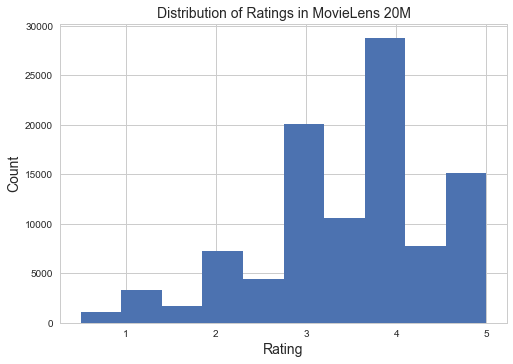

In [21]:
plt.hist(data['rating'])
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of Ratings in MovieLens 20M", fontsize=14)
plt.show()

In [22]:
print("user id min/max: ", data['userId'].min(), data['userId'].max())
print("# unique users: ", numpy.unique(data['userId']).shape[0])
print("")
print("movie id min/max: ", data['movieId'].min(), data['movieId'].max())
print("# unique movies: ", numpy.unique(data['movieId']).shape[0])

user id min/max:  1 671
# unique users:  671

movie id min/max:  1 163949
# unique movies:  9066


In [23]:
n_users, n_movies = data['userId'].max(), data['movieId'].max()
batch_size = 15000

In [24]:
n = 90000

data = data.sample(frac=1).reset_index(drop=True) # Shuffle the data in place row-wise

# Use the first 19M samples to train the model
train_users = data['userId'].values[:n] - 1 # Offset by 1 so that the IDs start at 0
train_movies = data['movieId'].values[:n] - 1 # Offset by 1 so that the IDs start at 0
train_ratings = data['rating'].values[:n]

# Use the remaining ~1M samples for validation of the model
valid_users = data['userId'].values[n:] - 1 # Offset by 1 so that the IDs start at 0
valid_movies = data['movieId'].values[n:] - 1 # Offset by 1 so that the IDs start at 0
valid_ratings = data['rating'].values[n:]

In [25]:
X_train = gluon.data.DataLoader(gluon.data.ArrayDataset(train_users.astype('float32'), train_movies.astype('float32'), train_ratings.astype('float32')),
                                      batch_size=batch_size, shuffle=True)

X_eval = gluon.data.DataLoader(gluon.data.ArrayDataset(valid_users.astype('float32'), valid_movies.astype('float32'), valid_ratings.astype('float32')),
                                      batch_size=batch_size, shuffle=True)

In [26]:
class Vanilla_MF_ml(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Vanilla_MF_ml, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.user = nn.Embedding(input_dim=n_users, output_dim=25)
            self.movie = nn.Embedding(input_dim=n_movies, output_dim=25)
            
    def hybrid_forward(self, F, user_i, movie_i):
        # Here `F` can be either mx.nd or mx.sym, x is the input data,
        user_i = self.user(user_i)
        movie_i = self.movie(movie_i)
        z = F.sum(F.dot(user_i, movie_i, transpose_b=True), axis = 1)
        return z

In [27]:
# model initialization
model = Vanilla_MF_ml()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)


learning_rate = 1e-4
criterion = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model.collect_params(), 'adam',
                          {'learning_rate': learning_rate,
                           'wd': 1e-5})

In [28]:
## Model Running (Training)
model = run_epoch(model, X_train, X_eval, num_epochs= 20)

epoch [1/20], (rmse) loss:2.5596, (rmse) val_loss:0.8348
epoch [2/20], (rmse) loss:2.4980, (rmse) val_loss:0.8262
epoch [3/20], (rmse) loss:2.4638, (rmse) val_loss:0.8166
epoch [4/20], (rmse) loss:2.4215, (rmse) val_loss:0.8068
epoch [5/20], (rmse) loss:2.3794, (rmse) val_loss:0.7917
epoch [6/20], (rmse) loss:2.3293, (rmse) val_loss:0.7754
epoch [7/20], (rmse) loss:2.2767, (rmse) val_loss:0.7610
epoch [8/20], (rmse) loss:2.2204, (rmse) val_loss:0.7427
epoch [9/20], (rmse) loss:2.1609, (rmse) val_loss:0.7259
epoch [10/20], (rmse) loss:2.0992, (rmse) val_loss:0.7075
epoch [11/20], (rmse) loss:2.0349, (rmse) val_loss:0.6895
epoch [12/20], (rmse) loss:1.9711, (rmse) val_loss:0.6703
epoch [13/20], (rmse) loss:1.9043, (rmse) val_loss:0.6527
epoch [14/20], (rmse) loss:1.8388, (rmse) val_loss:0.6340
epoch [15/20], (rmse) loss:1.7745, (rmse) val_loss:0.6163
epoch [16/20], (rmse) loss:1.7100, (rmse) val_loss:0.6001
epoch [17/20], (rmse) loss:1.6451, (rmse) val_loss:0.5823
epoch [18/20], (rmse) l

In [29]:
class Deep_MF_ml(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Deep_MF_ml, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.user = nn.Embedding(input_dim=n_users, output_dim=25)
            self.movie = nn.Embedding(input_dim=n_movies, output_dim=25)
            
            
            self.out = gluon.nn.HybridSequential('output_')
            with self.out.name_scope():
                self.out.add(nn.Flatten())
                self.out.add(nn.Dense(64, activation='relu')) # encoding & latent layer
                self.out.add(gluon.nn.BatchNorm(axis=1, center=True, scale=True))
                self.out.add(nn.Dense(64, activation='relu')) # encoding & latent layer
                self.out.add(gluon.nn.BatchNorm(axis=1, center=True, scale=True))
                self.out.add(nn.Dense(1)) # encoding & latent layer
            
    def hybrid_forward(self, F, user_i, movie_i):
        # Here `F` can be either mx.nd or mx.sym, x is the input data,
        user_i = self.user(user_i)
        movie_i = self.movie(movie_i)
        
        z = F.concat(user_i, movie_i)
        z = self.out(z)
        return z

In [30]:
# model initialization
model = Deep_MF_ml()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)


learning_rate = 1e-2
criterion = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model.collect_params(), 'adam',
                          {'learning_rate': learning_rate,
                           'wd': 1e-5})

In [31]:
## Model Running (Training)
model = run_epoch(model, X_train, X_eval, num_epochs= 100)

epoch [1/100], (rmse) loss:2.5020, (rmse) val_loss:0.7430
epoch [2/100], (rmse) loss:1.9978, (rmse) val_loss:0.5525
epoch [3/100], (rmse) loss:1.3143, (rmse) val_loss:0.3040
epoch [4/100], (rmse) loss:0.6309, (rmse) val_loss:0.2597
epoch [5/100], (rmse) loss:0.7364, (rmse) val_loss:0.3032
epoch [6/100], (rmse) loss:0.6480, (rmse) val_loss:0.2341
epoch [7/100], (rmse) loss:0.4543, (rmse) val_loss:0.2354
epoch [8/100], (rmse) loss:0.4829, (rmse) val_loss:0.2416
epoch [9/100], (rmse) loss:0.4428, (rmse) val_loss:0.2334
epoch [10/100], (rmse) loss:0.3936, (rmse) val_loss:0.2366
epoch [11/100], (rmse) loss:0.3915, (rmse) val_loss:0.2378
epoch [12/100], (rmse) loss:0.3707, (rmse) val_loss:0.2370
epoch [13/100], (rmse) loss:0.3584, (rmse) val_loss:0.2385
epoch [14/100], (rmse) loss:0.3496, (rmse) val_loss:0.2400
epoch [15/100], (rmse) loss:0.3411, (rmse) val_loss:0.2418
epoch [16/100], (rmse) loss:0.3342, (rmse) val_loss:0.2432
epoch [17/100], (rmse) loss:0.3287, (rmse) val_loss:0.2438
epoch 

In [32]:
# Regression 형태가 아닌 Classification 문제로 변환
# movielens의 경우 0.5 ~ 5까지 0.5구간으로 평점이 존재하며 이에 따라 총 10개의 class인 문제로 표현 가능
class Deep_MF_ml_class(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Deep_MF_ml_class, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.user = nn.Embedding(input_dim=n_users, output_dim=25)
            self.movie = nn.Embedding(input_dim=n_movies, output_dim=25)
            
            
            self.out = gluon.nn.HybridSequential('output_')
            with self.out.name_scope():
                self.out.add(nn.Flatten())
                self.out.add(nn.Dense(64, activation='relu')) # encoding & latent layer
                self.out.add(gluon.nn.BatchNorm(axis=1, center=True, scale=True))
                self.out.add(nn.Dense(64, activation='relu')) # encoding & latent layer
                self.out.add(gluon.nn.BatchNorm(axis=1, center=True, scale=True))
                self.out.add(nn.Dense(10)) # encoding & latent layer
            
    def hybrid_forward(self, F, user_i, movie_i):
        # Here `F` can be either mx.nd or mx.sym, x is the input data,
        user_i = self.user(user_i)
        movie_i = self.movie(movie_i)
        
        z = F.concat(user_i, movie_i)
        z = self.out(z)
        return z

In [33]:
# model initialization
model = Deep_MF_ml_class()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)


learning_rate = 1e-3
criterion = gluon.loss.SoftmaxCrossEntropyLoss()
optimizer = gluon.Trainer(model.collect_params(), 'adam',
                          {'learning_rate': learning_rate,
                           'wd': 1e-5})

In [34]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    
    for user, movie, rating in data_iterator:
        user = user.as_in_context(ctx)
        movie = movie.as_in_context(ctx)
        rating = rating.as_in_context(ctx)
    
        output = net(user, movie)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=rating)
    return acc.get()[1]

In [35]:
num_epochs = 100             
              
for epoch in range(num_epochs):
    running_loss = 0.0
    val_loss = 0.0
    n_total = 0.0

    # for training
    for user, movie, rating in X_train:
        user = user.as_in_context(ctx)
        movie = movie.as_in_context(ctx)
        rating = rating.as_in_context(ctx)

        with mx.autograd.record():
            output = model(user, movie)
            loss = criterion(output, rating)
        loss.backward()
        optimizer.step(user.shape[0])
        running_loss += mx.nd.sum(loss).asscalar()
        n_total += user.shape[0]

    for val_user, val_movie, val_rating in X_eval:
        val_user = val_user.as_in_context(ctx)
        val_movie = val_movie.as_in_context(ctx)

        with mx.autograd.record():
            val_output = model(val_user, val_movie)
            val_loss_tmp = criterion(val_output, val_rating)
        val_loss += mx.nd.sum(val_loss_tmp).asscalar()
    
    train_accuracy = evaluate_accuracy(X_train, model)
    test_accuracy = evaluate_accuracy(X_eval, model)
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}, val_loss:{:.4f}, train_acc:{:.4f}, val_acc:{:.4f}'
          .format(epoch + 1, num_epochs, np.sqrt(running_loss / n_total), np.sqrt(val_loss / n_total), train_accuracy, test_accuracy))

epoch [1/100], loss:1.6553, val_loss:0.5247, train_acc:0.0042, val_acc:0.0029
epoch [2/100], loss:1.5102, val_loss:0.5002, train_acc:0.0103, val_acc:0.0091
epoch [3/100], loss:1.4309, val_loss:0.4866, train_acc:0.0988, val_acc:0.0920
epoch [4/100], loss:1.3723, val_loss:0.4774, train_acc:0.1688, val_acc:0.1607
epoch [5/100], loss:1.3213, val_loss:0.4715, train_acc:0.1743, val_acc:0.1660
epoch [6/100], loss:1.2755, val_loss:0.4682, train_acc:0.1771, val_acc:0.1691
epoch [7/100], loss:1.2333, val_loss:0.4662, train_acc:0.1803, val_acc:0.1701
epoch [8/100], loss:1.1942, val_loss:0.4649, train_acc:0.2024, val_acc:0.1752
epoch [9/100], loss:1.1573, val_loss:0.4645, train_acc:0.3224, val_acc:0.2262
epoch [10/100], loss:1.1229, val_loss:0.4646, train_acc:0.4837, val_acc:0.3095
epoch [11/100], loss:1.0901, val_loss:0.4656, train_acc:0.5933, val_acc:0.3638
epoch [12/100], loss:1.0594, val_loss:0.4675, train_acc:0.6474, val_acc:0.3917
epoch [13/100], loss:1.0304, val_loss:0.4699, train_acc:0.679

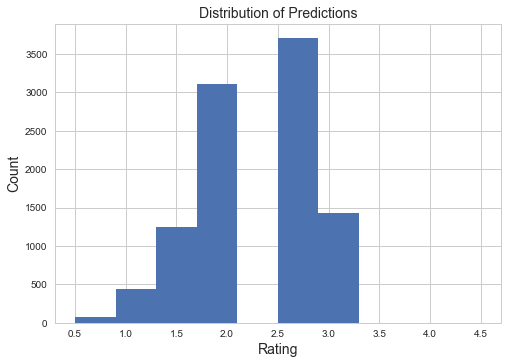

In [36]:
user_set = mx.nd.array((valid_users.astype('float32')))
movie_set = mx.nd.array((valid_movies.astype('float32')))

y_pred = model(user_set, movie_set).asnumpy().argmax(axis=1)
y_pred = (y_pred + 1.) / 2

plt.title("Distribution of Predictions", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Rating", fontsize=14)
plt.hist(y_pred)
plt.show()

In [37]:
numpy.sqrt(((y_pred - valid_ratings) ** 2).mean())

1.6769615737851655